In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import joblib
import pickle

In [3]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve

from sklearn.metrics import r2_score,recall_score,accuracy_score,roc_curve,roc_auc_score,f1_score,\
                            confusion_matrix,classification_report

In [5]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width",200)
pd.set_option("display.float_format" , lambda x : "%.4f" %x)

In [6]:
from warnings import filterwarnings
filterwarnings("ignore")

In [7]:
# max_depth ne kadar dallanma olacağı demektir
# max_feature bölünmelerde gerçekleşecek bölünme sayısı
# min_samples_split dallandı dallandı 2 tane kaldı bölmicek kararı kaç girdiysek ona göre vericek
# n_estimators birbirinden bağımsız seçtiğimiz adet kadar ağaç kurucak ....

In [8]:
df = pickle.load(open("diabetes.pkl","rb"))

In [9]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_1,NEW_AGE_CAT_1,NEW_BMI_AGE_1,NEW_BMI_AGE_2,NEW_BMI_AGE_3,NEW_BMI_AGE_4,NEW_BMI_AGE_5,NEW_BMI_AGE_6,NEW_AGE_GLUCOSE_1,NEW_AGE_GLUCOSE_2,NEW_AGE_GLUCOSE_3,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_GLUCOSE_1
0,0.6471,0.8646,-0.0308,0.8143,0.6269,0.1840,0.5889,1.4457,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1
1,-0.8490,-1.2047,-0.5437,0.0201,-0.5266,-0.8657,-0.3781,-0.1893,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1.2456,2.0143,-0.7146,0.4172,0.6269,-1.3606,0.7466,-0.1033,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,-0.8490,-1.0733,-0.5437,-0.7742,-0.6729,-0.6407,-1.0228,-1.0498,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,-1.1482,0.5033,-2.7661,0.8143,0.6011,1.6087,2.5966,-0.0172,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [10]:
X = df.drop("Outcome", axis = 1)
y = df["Outcome"]

In [11]:
rf_params = {"max_depth" : [5,8,15,None],
             "max_features" : [5,7,"auto"],
             "min_samples_split" : [8,15,20],
             "n_estimators" : [200,500,1000]}

knn_params = {"n_neighbors" :range(2,50)}

cart_params = {"max_depth" : range(1,20),
               "min_samples_split" : range(2,30)}

gbm_params = {"learning_rate" : [0.01, 0.1],
              "max_depth" : [3,8],
              "n_estimators" :[500, 100],
              "subsample" : [1, 0.5, 0.7]}

xgboost_params = {"learning_rate" : [0.01 ,0.1 ,0.2],
                  "max_depth" : [5, 8, 12 ,20],
                  "n_estimators" : [100,200,300,400],
                  "colsample_bytree" : [0.5, 0.8, 1]}

light_params = {"learning_rate" : [0.01, 0.1],
                "n_estimators" : [300,500,1500],
                "colsample_bytree" :[.5, .7 ,1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}




classifiers = [ ("RF",RandomForestClassifier(),rf_params ),
                ("KNN", KNeighborsClassifier(),knn_params), 
                ("CART", DecisionTreeClassifier(),cart_params),
                ("GBM",GradientBoostingClassifier(),gbm_params),
                ("XGBoost",XGBClassifier(),xgboost_params),
                ("LightGBM",LGBMClassifier(),light_params),
                ("CatBoost",CatBoostClassifier(),catboost_params)  ]

In [12]:
def base_model(classifiers, X, y , cv = 3):
    
    data = pd.DataFrame()
    index = 0
    
    for name,classifier,params in classifiers:
        
        cv_results = cross_validate(estimator=classifier,
                                    X = X,
                                    y = y ,
                                    cv = cv,
                                    n_jobs= -1,
                                    verbose=0,
                                    scoring=["roc_auc","accuracy"])
        
        roc_auc_score = cv_results["test_roc_auc"].mean()
        accuracy_score = cv_results["test_accuracy"].mean()
        fit_time = cv_results["fit_time"].mean()
        score_time = cv_results["score_time"].mean()
        
        data.loc[index , "NAME"] = name.upper()
        data.loc[index, "ROC_AUC_SCORE"] = roc_auc_score
        data.loc[index, "ACCURACY_SCORE"] = accuracy_score
        data.loc[index, "FIT_TIME"] = fit_time
        data.loc[index, "SCORE_TIME"] = score_time
        index+=1
        
    data = data.set_index("NAME")
    data = data.sort_values(by = "ROC_AUC_SCORE", ascending = False)

    return data

In [13]:
base_model(classifiers, X, y)

,ROC_AUC_SCORE,ACCURACY_SCORE,FIT_TIME,SCORE_TIME
NAME,,,,
LIGHTGBM,0.9505,0.8854,0.0474,0.0076
GBM,0.9488,0.8906,0.0862,0.0036
XGBOOST,0.9471,0.8789,0.1829,0.0039
CATBOOST,0.9465,0.8802,1.6765,0.0054
RF,0.9403,0.8815,0.0983,0.0153
KNN,0.8805,0.8203,0.0024,0.0126
CART,0.8429,0.8620,0.0033,0.0027


In [14]:
######################################################
# Automated Hyperparameter Optimization
######################################################

**Here we chose 3 models with high value.**

In [15]:
classifiers = [ #("RF",RandomForestClassifier(),rf_params ),
                #("KNN", KNeighborsClassifier(),knn_params), 
                #("CART", DecisionTreeClassifier(),cart_params),
                ("GBM",GradientBoostingClassifier(),gbm_params),
                ("XGBoost",XGBClassifier(eval_metric='mlogloss'),xgboost_params),
                ("LightGBM",LGBMClassifier(),light_params),
                #("CatBoost",CatBoostClassifier(),catboost_params)  
               ]

In [16]:
def hyperparameter_optimization(classifiers , X ,y , cv = 3):
    
    models_best = {}
    data = pd.DataFrame()
    index = 0
    
    for name, classifier, params in classifiers:
        
        cv_results = cross_validate(estimator=classifier,
                                    X = X,
                                    y = y,
                                    cv = cv,
                                    n_jobs= -1 ,
                                    scoring = ["roc_auc","accuracy"],
                                    verbose=0)
        
        roc_auc_score = round(cv_results["test_roc_auc"].mean(),4)
        accuracy_score = round(cv_results["test_accuracy"].mean(),4)
        
        print("".center(50,"#"),end = "\n\n")
        print(f"Before GridSearchCV For {type(classifier).__name__.upper()}",end = "\n\n")
        print(f"ROC AUC Score : {roc_auc_score}\nAccuracy Score : {accuracy_score}",end = "\n\n")
        
        best_grid = GridSearchCV(estimator= classifier, 
                                 param_grid=params ,
                                 n_jobs=-1,
                                 verbose=0,
                                 cv = cv).fit(X,y)
        
        print(f"Best Params For {type(classifier).__name__.upper()}:\n\n{best_grid.best_params_}",end = "\n\n")
        
        final_classifier = classifier.set_params(**best_grid.best_params_)
        
        final_cv_results = cross_validate(estimator=final_classifier,
                                          X = X,
                                          y = y,
                                          cv = cv,
                                          n_jobs= -1 ,
                                          scoring = ["roc_auc","accuracy"],
                                          verbose=0)
        
        final_roc_auc_score = round(final_cv_results["test_roc_auc"].mean(),4)
        final_accuracy_score = round(final_cv_results["test_accuracy"].mean(),4)
        
        print(f"After GridSearchCV For {type(final_classifier).__name__.upper()}",end = "\n\n")
        print(f"ROC AUC Score : {final_roc_auc_score}\nAccuracy Score : {final_accuracy_score}",end = "\n\n")
        
        
        data.loc[index, "NAME"] = name.upper()
        data.loc[index, "BEFORE_ROC_AUC"] = roc_auc_score
        data.loc[index, "BEFORE_ACCURACY"] = accuracy_score
        data.loc[index, "AFTER_ROC_AUC"] = final_roc_auc_score
        data.loc[index, "AFTER_ACCURACY"] = final_accuracy_score
        index+=1
        
        models_best[name] = final_classifier
        
    data = data.set_index("NAME")
    data = data.sort_values(by = "AFTER_ROC_AUC", ascending = False)
    
    return data , models_best

In [17]:
data , models_best = hyperparameter_optimization(classifiers, X , y ,cv = 10)

##################################################

Before GridSearchCV For GRADIENTBOOSTINGCLASSIFIER

ROC AUC Score : 0.9587
Accuracy Score : 0.8803

Best Params For GRADIENTBOOSTINGCLASSIFIER:

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.7}

After GridSearchCV For GRADIENTBOOSTINGCLASSIFIER

ROC AUC Score : 0.9504
Accuracy Score : 0.8881

##################################################

Before GridSearchCV For XGBCLASSIFIER

ROC AUC Score : 0.95
Accuracy Score : 0.8816

Best Params For XGBCLASSIFIER:

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}

After GridSearchCV For XGBCLASSIFIER

ROC AUC Score : 0.9555
Accuracy Score : 0.8959

##################################################

Before GridSearchCV For LGBMCLASSIFIER

ROC AUC Score : 0.953
Accuracy Score : 0.8855

Best Params For LGBMCLASSIFIER:

{'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}

After GridSearchCV For LGBMCLASSIFIER

ROC

In [18]:
data

,BEFORE_ROC_AUC,BEFORE_ACCURACY,AFTER_ROC_AUC,AFTER_ACCURACY
NAME,,,,
LIGHTGBM,0.9530,0.8855,0.9575,0.8920
XGBOOST,0.9500,0.8816,0.9555,0.8959
GBM,0.9587,0.8803,0.9504,0.8881


In [19]:
for model in models_best.keys():
    pd.to_pickle(models_best[model], open(model+"_diabetes.pkl","wb"))

In [20]:
######################################################
# Stacking & Ensemble Learning
######################################################

In [21]:
def voting_classifiers(models_best, X, y, cv = 5):

    estimators = [(name,models_best[name]) for name in models_best ]

    voting_clf = VotingClassifier(estimators=estimators,voting="soft",n_jobs=-1,verbose=0).fit(X,y)
    
    cv_results = cross_validate(estimator=voting_clf,
                                X = X,
                                y = y ,
                                cv = cv ,
                                n_jobs=-1,
                                verbose=0,
                                scoring=["roc_auc","accuracy"])
    
    data = pd.DataFrame()
    data["NAME"] = ["VotingClassifier"]
    data["ROC_AUC"] = cv_results["test_roc_auc"].mean()
    data["ACCURACY"] = cv_results["test_accuracy"].mean()
    data["FIT_TIME"] = cv_results["fit_time"].mean()
    data["SCORE_TIME"] = cv_results["score_time"].mean()
    
    data = data.set_index("NAME")
    
    return data, voting_clf

In [22]:
data_voting, voting_clf = voting_classifiers(models_best, X, y, cv = 10)

In [23]:
data_voting

,ROC_AUC,ACCURACY,FIT_TIME,SCORE_TIME
NAME,,,,
VotingClassifier,0.9593,0.8907,3.9695,0.0239


In [24]:
data

,BEFORE_ROC_AUC,BEFORE_ACCURACY,AFTER_ROC_AUC,AFTER_ACCURACY
NAME,,,,
LIGHTGBM,0.9530,0.8855,0.9575,0.8920
XGBOOST,0.9500,0.8816,0.9555,0.8959
GBM,0.9587,0.8803,0.9504,0.8881


In [25]:
################################################
# Feature Importance
################################################

In [26]:
final_model = models_best["XGBoost"].fit(X,y)
final_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [27]:
len(final_model.feature_importances_),len(X.columns)

(23, 23)

In [28]:
def plot_importance(model , feature_names, num = 10, save = False):
    
    feature_imp = pd.DataFrame({"Value" : model.feature_importances_,
                                "Feature": feature_names.columns})
    plt.figure(figsize = (10,7))
    sns.set(font_scale = 1)
    
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", 
                                                                           ascending = False)[0:num])
    
    plt.title("Feature")    
    plt.tight_layout()
    plt.show()
    
    if save :
        plt.savefig("new_importances.png")

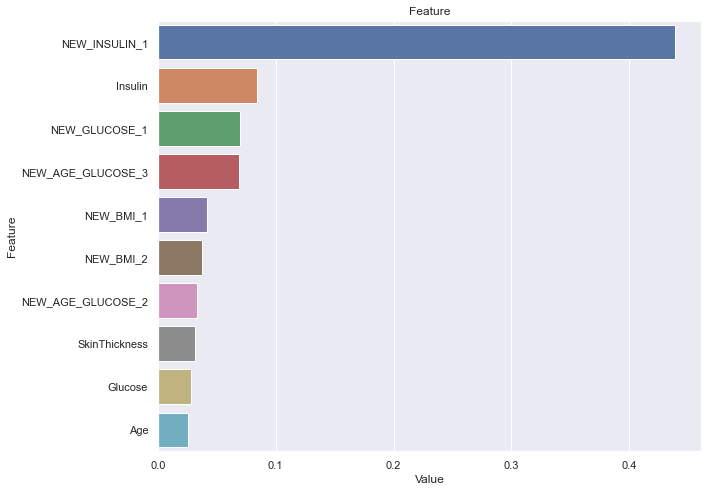

<Figure size 432x288 with 0 Axes>

In [29]:
plot_importance(final_model, X , save = True)

In [30]:
################################################
# Analyzing Model Complexity with Learning Curves (BONUS)
################################################

In [40]:
xgboost_params = {"learning_rate" : [0.01 ,0.1 ,0.2],
                  "max_depth" : [5, 8, 12 ,20],
                  "n_estimators" : [100,200,300,400],
                  "colsample_bytree" : [0.5, 0.8, 1]}

In [33]:
def val_curve_params(models, X, y, param_name, param_range, cv = 10, scoring = "roc_auc"):

    train_scores, test_scores =validation_curve(estimator=final_model,
                                                X= X, 
                                                y = y,
                                                param_name = param_name ,
                                                param_range= param_range,
                                                n_jobs = -1, 
                                                verbose =0,
                                                cv = cv,
                                                scoring = scoring)
    
    mean_train_scores = np.mean(train_scores ,axis = 1)
    mean_test_scores = np.mean(test_scores, axis = 1)
    
    plt.plot(param_range, mean_train_scores, label = "Training Score", color = "b")
    plt.plot(param_range, mean_test_scores, label = "Validation Score", color = "g")
    
    plt.title(f"Validation Curve For {type(models).__name__.upper()}")
    plt.xlabel(f"Number Of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.legend(loc = "best")
    plt.show()
    

In [37]:
models_best["XGBoost"].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 20,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'mlogloss'}

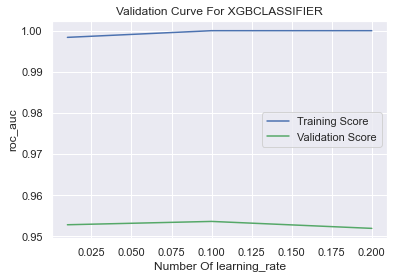

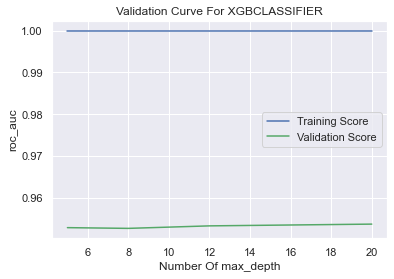

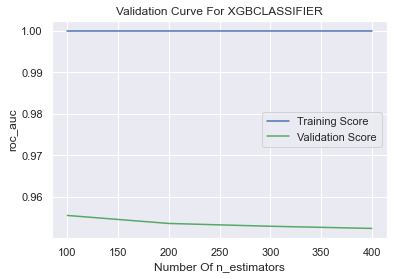

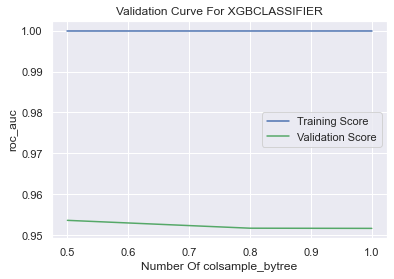

In [41]:
for param in xgboost_params:
    val_curve_params(models=final_model,
                     X = X,
                     y = y,
                     param_name= param,
                     param_range=xgboost_params[param],
                     cv = 5,
                     scoring="roc_auc")

In [48]:
######################################################
# Prediction for a New Observation
######################################################

In [49]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'NEW_INSULIN_1', 'NEW_AGE_CAT_1', 'NEW_BMI_AGE_1', 'NEW_BMI_AGE_2',
       'NEW_BMI_AGE_3', 'NEW_BMI_AGE_4', 'NEW_BMI_AGE_5', 'NEW_BMI_AGE_6', 'NEW_AGE_GLUCOSE_1', 'NEW_AGE_GLUCOSE_2', 'NEW_AGE_GLUCOSE_3', 'NEW_BMI_1', 'NEW_BMI_2', 'NEW_BMI_3', 'NEW_GLUCOSE_1'],
      dtype='object')

In [67]:
random_user = X.sample(1)

y.loc[random_user.index]

128    1
Name: Outcome, dtype: int64

In [68]:
final_model.predict(random_user)[0]

1